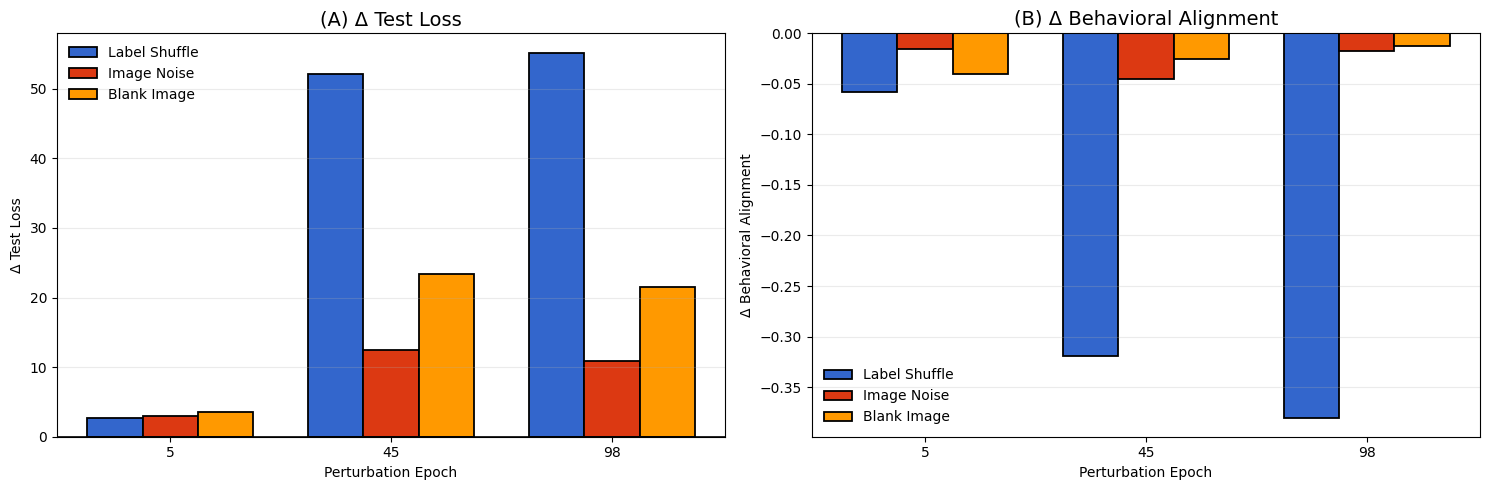

In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np


# =============================================================================
# LOAD BASELINE (TRIM AT MIN TEST LOSS)
# =============================================================================

baseline_seed1_csv = Path(
    '/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/'
    'baseline_runs/clip_hba_behavior_seed1/training_results/training_res_seed1.csv'
)

baseline_df = pd.read_csv(baseline_seed1_csv)
baseline_min_idx = baseline_df['test_loss'].idxmin()
baseline_df = baseline_df.loc[:baseline_min_idx].copy()


# =============================================================================
# HELPERS
# =============================================================================

def load_run_epoch_value(root_dir, run_number):
    """Load test_loss at epoch == run_number."""
    run_dir = Path(root_dir) / f"training_run{run_number}"
    csv_file = run_dir / f"training_res_run{run_number}.csv"

    if not csv_file.exists():
        print(f"[WARNING] Missing run {run_number}")
        return None

    df = pd.read_csv(csv_file)

    if "epoch" not in df.columns:
        return None

    row = df[df['epoch'] == run_number]
    if len(row) == 0:
        return None

    return float(row.iloc[0]["test_loss"])


def baseline_epoch_loss(epoch):
    """Return baseline loss at same epoch."""
    if epoch not in baseline_df["epoch"].values:
        print(f"[WARNING] Baseline missing epoch {epoch}")
        return None
    return float(baseline_df[baseline_df["epoch"] == epoch]["test_loss"].iloc[0])


def load_all_run_data(root):
    """Load all training_run*/training_res_run*.csv into dict."""
    root = Path(root)
    all_data = {}
    
    for run_dir in sorted(root.glob("training_run*")):
        if run_dir.is_dir():
            run_num = run_dir.name.split("run")[1]
            csv = run_dir / f"training_res_run{run_num}.csv"
            if csv.exists():
                all_data[run_dir.name] = pd.read_csv(csv)
    return all_data


def compute_ba_from_dict(all_data, baseline_df, target_epochs):
    """Compute Δ behavioral alignment."""
    deviations = []
    for epoch in target_epochs:
        run_name = f"training_run{epoch}"

        if run_name not in all_data:
            deviations.append(np.nan)
            continue

        df = all_data[run_name]
        row = df[df['epoch'] == epoch]
        base_row = baseline_df[baseline_df['epoch'] == epoch]

        if len(row) == 0 or len(base_row) == 0:
            deviations.append(np.nan)
            continue

        run_ba = float(row.iloc[0]["behavioral_rsa_rho"])
        base_ba = float(base_row.iloc[0]["behavioral_rsa_rho"])

        deviations.append(run_ba - base_ba)

    return deviations


# =============================================================================
# ROOTS
# =============================================================================

label_shuffle_root = '/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/label_shuffle_single_epoch_perturbation_sweeps'
image_noise_root  = '/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/image_noise_single_epoch_perturbation_sweeps'
blank_image_root  = '/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/uniform_image_single_epoch_perturbation_sweeps'
target_noise_root = '/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/perturb_sweep_baselineseed1_perturbseed42'

# =============================================================================
# COMPUTE Δ TEST LOSS FOR EPOCHS 5, 45, 98
# =============================================================================

target_epochs = [5, 45, 98]

def compute_deltas(root):
    deviations = []
    for ep in target_epochs:
        run_loss = load_run_epoch_value(root, ep)
        base_loss = baseline_epoch_loss(ep)
        if run_loss is None or base_loss is None:
            deviations.append(np.nan)
        else:
            deviations.append(run_loss - base_loss)
    return deviations

ls_dev = compute_deltas(label_shuffle_root)
in_dev = compute_deltas(image_noise_root)
bi_dev = compute_deltas(blank_image_root)


# =============================================================================
# LOAD PER-RUN CSVs AND COMPUTE Δ BEHAVIORAL ALIGNMENT
# =============================================================================

all_shuffle_label_data = load_all_run_data(label_shuffle_root)
all_image_noise_data  = load_all_run_data(image_noise_root)
all_blank_image_data  = load_all_run_data(blank_image_root)

ls_ba = compute_ba_from_dict(all_shuffle_label_data, baseline_df, target_epochs)
in_ba = compute_ba_from_dict(all_image_noise_data, baseline_df, target_epochs)
bi_ba = compute_ba_from_dict(all_blank_image_data, baseline_df, target_epochs)


# =============================================================================
# PREPARE MATRICES FOR GROUPED PLOTS
# =============================================================================

test_loss_matrix = np.array([ls_dev, in_dev, bi_dev])
behavior_matrix  = np.array([ls_ba, in_ba, bi_ba])

perturb_names = ["Label Shuffle", "Image Noise", "Blank Image"]
epochs = target_epochs

x = np.arange(len(epochs))
bar_width = 0.25
offsets = [-bar_width, 0, bar_width]


# =============================================================================
# PLOT FIGURE
# =============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

colors = ["#3366CC", "#DC3912", "#FF9900"]


# ---- Panel A: Δ Test Loss ----
for i in range(3):
    ax1.bar(
        x + offsets[i],
        test_loss_matrix[i],
        width=bar_width,
        label=perturb_names[i],
        color=colors[i],
        edgecolor='black',
        linewidth=1.3
    )

ax1.axhline(0, color='black', linewidth=1.2)
ax1.set_xticks(x)
ax1.set_xticklabels(epochs)
ax1.set_title("(A) Δ Test Loss", fontsize=14)
ax1.set_xlabel("Perturbation Epoch")
ax1.set_ylabel("Δ Test Loss")
ax1.grid(axis="y", alpha=0.25)
ax1.legend(frameon=False)


# ---- Panel B: Δ Behavioral Alignment ----
for i in range(3):
    ax2.bar(
        x + offsets[i],
        behavior_matrix[i],
        width=bar_width,
        label=perturb_names[i],
        color=colors[i],
        edgecolor='black',
        linewidth=1.3
    )

ax2.axhline(0, color='black', linewidth=1.2)
ax2.set_xticks(x)
ax2.set_xticklabels(epochs)
ax2.set_title("(B) Δ Behavioral Alignment", fontsize=14)
ax2.set_xlabel("Perturbation Epoch")
ax2.set_ylabel("Δ Behavioral Alignment")
ax2.grid(axis="y", alpha=0.25)
ax2.legend(frameon=False)


plt.tight_layout()
plt.show()


## Supplemental Revision

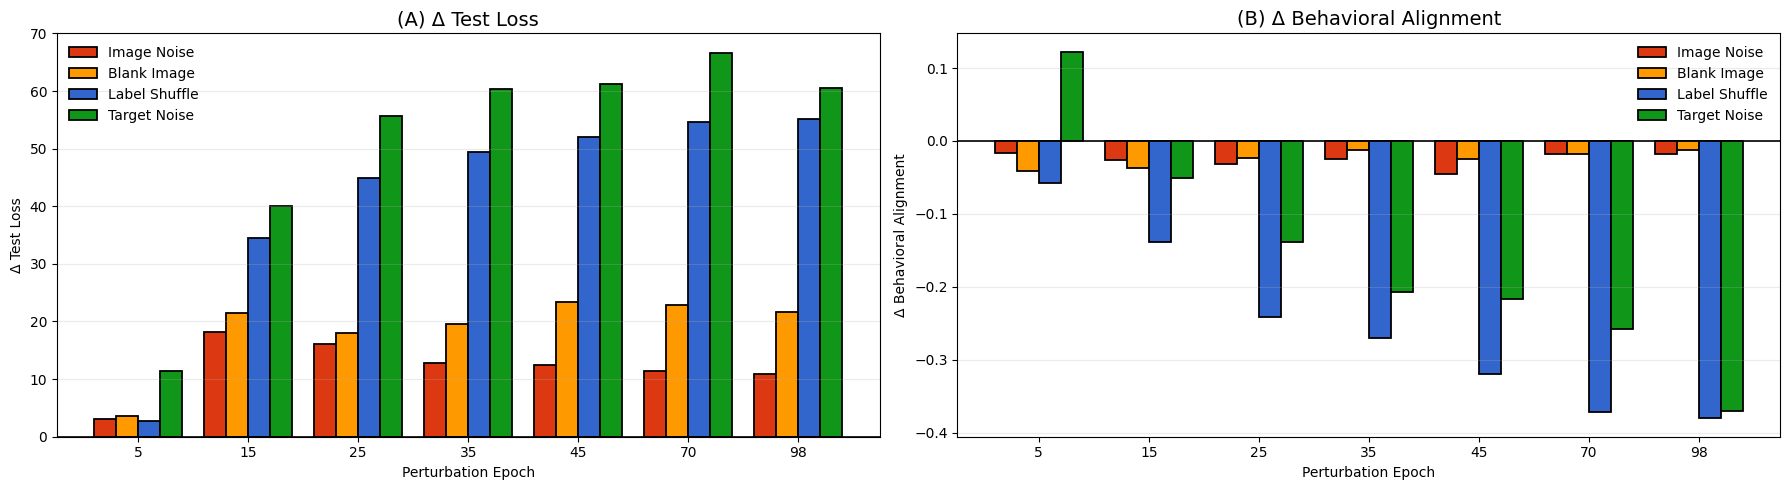

In [8]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np


# =============================================================================
# LOAD BASELINE (TRIM AT MIN TEST LOSS)
# =============================================================================

baseline_seed1_csv = Path(
    '/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/'
    'baseline_runs/clip_hba_behavior_seed1/training_results/training_res_seed1.csv'
)

baseline_df = pd.read_csv(baseline_seed1_csv)
baseline_min_idx = baseline_df['test_loss'].idxmin()
baseline_df = baseline_df.loc[:baseline_min_idx].copy()


# =============================================================================
# HELPERS
# =============================================================================

def load_run_epoch_value(root_dir, run_number):
    """Load test_loss at epoch == run_number."""
    run_dir = Path(root_dir) / f"training_run{run_number}"
    csv_file = run_dir / f"training_res_run{run_number}.csv"

    if not csv_file.exists():
        print(f"[WARNING] Missing run {run_number}")
        return None

    df = pd.read_csv(csv_file)

    if "epoch" not in df.columns:
        return None

    row = df[df['epoch'] == run_number]
    if len(row) == 0:
        return None

    return float(row.iloc[0]["test_loss"])


def baseline_epoch_loss(epoch):
    """Return baseline loss at same epoch."""
    if epoch not in baseline_df["epoch"].values:
        print(f"[WARNING] Baseline missing epoch {epoch}")
        return None
    return float(baseline_df[baseline_df["epoch"] == epoch]["test_loss"].iloc[0])


def load_all_run_data(root):
    """Load all training_run*/training_res_run*.csv into dict."""
    root = Path(root)
    all_data = {}
    
    for run_dir in sorted(root.glob("training_run*")):
        if run_dir.is_dir():
            run_num = run_dir.name.split("run")[1]
            csv = run_dir / f"training_res_run{run_num}.csv"
            if csv.exists():
                all_data[run_dir.name] = pd.read_csv(csv)
    return all_data


def compute_ba_from_dict(all_data, baseline_df, target_epochs):
    """Compute Δ behavioral alignment."""
    deviations = []
    for epoch in target_epochs:
        run_name = f"training_run{epoch}"

        if run_name not in all_data:
            deviations.append(np.nan)
            continue

        df = all_data[run_name]
        row = df[df['epoch'] == epoch]
        base_row = baseline_df[baseline_df['epoch'] == epoch]

        if len(row) == 0 or len(base_row) == 0:
            deviations.append(np.nan)
            continue

        run_ba = float(row.iloc[0]["behavioral_rsa_rho"])
        base_ba = float(base_row.iloc[0]["behavioral_rsa_rho"])

        deviations.append(run_ba - base_ba)

    return deviations


# =============================================================================
# ROOTS
# =============================================================================

label_shuffle_root = '/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/label_shuffle_single_epoch_perturbation_sweeps'
image_noise_root  = '/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/image_noise_single_epoch_perturbation_sweeps'
blank_image_root  = '/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/uniform_image_single_epoch_perturbation_sweeps'
target_noise_root = '/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/perturb_sweep_baselineseed1_perturbseed42'

# =============================================================================
# COMPUTE Δ TEST LOSS FOR EXPANDED EPOCHS
# =============================================================================

target_epochs = [5, 15, 25, 35, 45, 70, 98]

def compute_deltas(root):
    deviations = []
    for ep in target_epochs:
        run_loss = load_run_epoch_value(root, ep)
        base_loss = baseline_epoch_loss(ep)
        if run_loss is None or base_loss is None:
            deviations.append(np.nan)
        else:
            deviations.append(run_loss - base_loss)
    return deviations

ls_dev = compute_deltas(label_shuffle_root)
in_dev = compute_deltas(image_noise_root)
bi_dev = compute_deltas(blank_image_root)
tn_dev = compute_deltas(target_noise_root)


# =============================================================================
# LOAD PER-RUN CSVs AND COMPUTE Δ BEHAVIORAL ALIGNMENT
# =============================================================================

all_shuffle_label_data = load_all_run_data(label_shuffle_root)
all_image_noise_data  = load_all_run_data(image_noise_root)
all_blank_image_data  = load_all_run_data(blank_image_root)
all_target_noise_data = load_all_run_data(target_noise_root)

ls_ba = compute_ba_from_dict(all_shuffle_label_data, baseline_df, target_epochs)
in_ba = compute_ba_from_dict(all_image_noise_data, baseline_df, target_epochs)
bi_ba = compute_ba_from_dict(all_blank_image_data, baseline_df, target_epochs)
tn_ba = compute_ba_from_dict(all_target_noise_data, baseline_df, target_epochs)


# =============================================================================
# PREPARE MATRICES FOR GROUPED PLOTS
# =============================================================================

test_loss_matrix = np.array([in_dev, bi_dev, ls_dev, tn_dev])
behavior_matrix  = np.array([in_ba, bi_ba, ls_ba, tn_ba])

perturb_names = ["Image Noise", "Blank Image", "Label Shuffle", "Target Noise"]
epochs = target_epochs

x = np.arange(len(epochs))
bar_width = 0.2
offsets = [-1.5*bar_width, -0.5*bar_width, 0.5*bar_width, 1.5*bar_width]


# =============================================================================
# PLOT FIGURE
# =============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5), sharex=True)

colors = ["#DC3912", "#FF9900", "#3366CC", "#109618"]


# ---- Panel A: Δ Test Loss ----
for i in range(4):
    ax1.bar(
        x + offsets[i],
        test_loss_matrix[i],
        width=bar_width,
        label=perturb_names[i],
        color=colors[i],
        edgecolor='black',
        linewidth=1.3
    )

ax1.axhline(0, color='black', linewidth=1.2)
ax1.set_xticks(x)
ax1.set_xticklabels(epochs)
ax1.set_title("(A) Δ Test Loss", fontsize=14)
ax1.set_xlabel("Perturbation Epoch")
ax1.set_ylabel("Δ Test Loss")
ax1.grid(axis="y", alpha=0.25)
ax1.legend(frameon=False)


# ---- Panel B: Δ Behavioral Alignment ----
for i in range(4):
    ax2.bar(
        x + offsets[i],
        behavior_matrix[i],
        width=bar_width,
        label=perturb_names[i],
        color=colors[i],
        edgecolor='black',
        linewidth=1.3
    )

ax2.axhline(0, color='black', linewidth=1.2)
ax2.set_xticks(x)
ax2.set_xticklabels(epochs)
ax2.set_title("(B) Δ Behavioral Alignment", fontsize=14)
ax2.set_xlabel("Perturbation Epoch")
ax2.set_ylabel("Δ Behavioral Alignment")
ax2.grid(axis="y", alpha=0.25)
ax2.legend(frameon=False)


plt.tight_layout()
plt.show()

In [ ]:
# After computing the matrices, print them
print("\nΔ Test Loss Matrix:")
print("Epochs:", target_epochs)
for i, name in enumerate(perturb_names):
    print(f"{name}: {test_loss_matrix[i]}")

print("\nΔ Behavioral Alignment Matrix:")
print("Epochs:", target_epochs)
for i, name in enumerate(perturb_names):
    print(f"{name}: {behavior_matrix[i]}")

# Or for specific values:
print(f"\nTarget Noise at epoch 5:")
print(f"  Δ Test Loss: {tn_dev[0]}")
print(f"  Δ Behavioral Alignment: {tn_ba[0]}")